In [1]:
import pandas as pd
import numpy as np
import re
import os, sys
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error,max_error,mean_absolute_percentage_error
import math
import time

# current_path = os.path.dirname(os.path.abspath(__file__))
current_path = '/workspace/laure/17_MCP/Reorg/'
sys.path.insert(0, os.path.join(current_path, 'src/'))
from MyFunctions import plot_ypredy_residuals

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Choose file:
choice = 'a'
if choice == 'a':
    file_name = '/data/MGP/TestPointsN2_CH4_H2O_000.xlsx'; pkl_fname='DataL2a_Full.pkl';DP='Differential Pressure [kPa]';shname='DontKnow'
elif choice=='b':
    file_name = '/data/MGP/TestPointsN2_CH4_H2O_100.xlsx'; pkl_fname='DataL2b_Full.pkl';DP='Differential Pressure';shname='DontKnow'
elif choice == 'c':
    file_name = '/data/MGP/TestPointsN2_CH4_OIL_100.xlsx'; pkl_fname='DataL2c_Full.pkl';DP='Differential Pressure [kPa]';shname='Sheet1'
elif choice == 'd':
    file_name = '/data/MGP/TestPointsN2_CH4_OIL_000.xlsx'; pkl_fname='DataL2d_Full.pkl';DP='Differential Pressure [kPa]';shname='DontKnow'
else:
    print('choice is a, b, c or d')  

In [3]:
if os.path.exists(pkl_fname):
    print('using existing pickle file')
else:
    if shname=='DontKnow':
        df=pd.read_excel(file_name,header=1).dropna(how='all', axis=1) 
    else:
        df=pd.read_excel(file_name,sheet_name=shname,header=1).dropna(how='all', axis=1)
    
    df.drop('#',axis=1,inplace=True)

    df.to_pickle(pkl_fname)

In [4]:
df=pd.read_pickle(pkl_fname)
print(df.shape)

(63116, 36)


In [5]:
pkl_fname  #TestPointsN2_CH4_H2O_000.xlsx

'DataL2a_Full.pkl'

In [6]:
if DP == 'Differential Pressure':
    df.rename(columns={DP: "Differential Pressure [kPa]"},inplace=True)

In [7]:
data=df[['Tin [K]','Pin [kPa]','N [rpm]','Total Consumed power','Differential Pressure [kPa]', 'Qin [m3/s]', 'Pout [kPA]', 'GVFin', 'Hp [kJ/kg]', 'GVFout','Qv_out [m3/s]','Surge Distance', 'phi']]

In [8]:
import math
data['phi eq']=data['Qin [m3/s]']/(data['N [rpm]']/60*2*math.pi*0.15*0.01885)
#plt.plot(data['phi'],data['phi eq'],'.')
max(data['phi']-data['phi eq'])  # there is a negligible difference between the original and calculated phi

6.938893903907228e-17

In [9]:
import math
data['phi eq']=data['Qin [m3/s]']/(data['N [rpm]']/60*2*math.pi*0.15*0.01885)
#plt.plot(data['phi'],data['phi eq'],'.')
max(data['phi']-data['phi eq'])  # there is a negligible difference between the original and calculated phi

6.938893903907228e-17

In [10]:
# since this xgb version does not recognise column names with square brackets, commas,\ they need to be replaced with _ 
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
# since this xgb version does not recognise column names with square brackets, commas need to replace the column names.
data.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in data.columns.values]

In [13]:
import pickle
# save
#with open('model_xgb.pkl','wb') as f:
#    pickle.dump(multioutputregressor_1,f)

# load
with open('/workspace/laure/17_MCP/002_Sensitivity/model_xgb.pkl', 'rb') as f:
    multioutputregressor_1 = pickle.load(f)

In [14]:
INPUT_C=['Tin _K_','Pin _kPa_','N _rpm_','Total Consumed power','Differential Pressure _kPa_'] #
OUTPUT_C =['GVFin','Qin _m3/s_','GVFout','Qv_out _m3/s_'] #,'Phi_Surge Eq','Hp _kJ/kg_','phi']
X_1=data[INPUT_C]
y_1=data[OUTPUT_C]

In [15]:
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split

train_X1, test_X1, train_y1, test_y1 = train_test_split(X_1, y_1, train_size=0.8, random_state=32)

In [16]:
train_X1.shape, test_X1.shape, train_y1.shape, test_y1.shape

((50492, 5), (12624, 5), (50492, 4), (12624, 4))

In [17]:
train_y=train_y1.copy() 
test_y=test_y1.copy() 

In [ ]:
#case 1: Introduce noise in the entire data for the feature 'Total Consumed power'
#case 2: Introduce noise in the test data for the feature 'Total Consumed power'

In [19]:
data_test_noise_power = data.iloc[test_y.index]

In [20]:
# gaussian or any other noise
mu,sigma  = 0, 0.1
noise = np.random.normal(mu, sigma)
data_test_noise_power['Total Consumed power']=data_test_noise_power['Total Consumed power']+noise

In [21]:
data_test_noise_X1= data_test_noise_power[['Tin _K_', 'Pin _kPa_', 'N _rpm_', 'Total Consumed power',
       'Differential Pressure _kPa_']]
predictions_noise_test_data = multioutputregressor_1.predict(data_test_noise_X1)

In [22]:
# after introducing noise in the test data only for power the results are as follows
print('Root_mean_squared_error_test set_noise',math.sqrt(mean_squared_error(test_y,predictions_noise_test_data)))
print('R2 Score_test set_xgb',r2_score(test_y,predictions_noise_test_data))

Root_mean_squared_error_test set_noise 1.4594181512382078
R2 Score_test set_xgb 0.9867906193406288


In [23]:

OUTPUT_C =['GVFin','Qin _m3/s_','GVFout','Qv_out _m3/s_']
for i, out in enumerate(OUTPUT_C):
    data_test_noise_power[out+'_pred'] = predictions_noise_test_data[:,i]

In [24]:
# get the results for all output variables and these results are for the test set with noise in power
#


dfppt=pd.DataFrame(columns=['Variable','Mean Val','RMSE','R²','ME','MAPE','Max Error pc'])
A=[];B=[];C=[];D=[];E=[];F=[];G=[]
for i, out in enumerate(OUTPUT_C):
    A.append(out)
    B.append(round(math.sqrt(mean_squared_error(test_y[out],data_test_noise_power[out+'_pred'])),4))
    C.append(round(r2_score(test_y[out],data_test_noise_power[out+'_pred']),4))
    D.append(round(max_error(test_y[out],data_test_noise_power[out+'_pred']),4))
    E.append(round(mean_absolute_percentage_error(test_y[out],data_test_noise_power[out+'_pred']),4))
    F.append(round(((test_y[out]-data_test_noise_power[out+'_pred'])/test_y[out]).max()*100,4 ))
    G.append(round(test_y[out].mean(),4))
    
dfppt['Variable']=A
dfppt['Mean Val']=G
dfppt['RMSE']=B
dfppt['R²']=C
dfppt['ME']=D
dfppt['MAPE']=E
dfppt['Max Error pc']=F
dfppt

,Variable,Mean Val,RMSE,R²,ME,MAPE,Max Error pc
0,GVFin,39.6849,2.1218,0.9903,15.7978,0.6870,247.3193
1,Qin _m3/s_,0.1043,0.0043,0.9835,0.0351,0.0283,23.0713
2,GVFout,37.5769,2.0044,0.9912,13.8258,0.6880,718.9378
3,Qv_out _m3/s_,0.1001,0.0042,0.9822,0.0367,0.0297,20.3417


In [26]:
data_test = data.iloc[test_y.index]

In [27]:
#get the results for all output variables and these results are for the test set actual power (with out noise in power)
#data_test

predictions_test_data = multioutputregressor_1.predict(data_test[INPUT_C])

In [28]:
print('Root_mean_squared_error_test set_',math.sqrt(mean_squared_error(test_y,predictions_test_data)))
print('R2 Score_test set_xgb',r2_score(test_y,predictions_test_data))

Root_mean_squared_error_test set_ 1.4527753840974846
R2 Score_test set_xgb 0.986838723936509


In [29]:
for i, out in enumerate(OUTPUT_C):
    data_test[out+'_pred'] = predictions_test_data[:,i]

In [30]:
# Nice table for metrics
dfppt=pd.DataFrame(columns=['Variable','Mean Val','RMSE','R²','ME','MAPE','Max Error pc'])
A=[];B=[];C=[];D=[];E=[];F=[];G=[]
for i, out in enumerate(OUTPUT_C):
    A.append(out)
    B.append(round(math.sqrt(mean_squared_error(test_y[out],data_test[out+'_pred'])),4))
    C.append(round(r2_score(test_y[out],data_test[out+'_pred']),4))
    D.append(round(max_error(test_y[out],data_test[out+'_pred']),4))
    E.append(round(mean_absolute_percentage_error(test_y[out],data_test[out+'_pred']),4))
    F.append(
        round(
            ((test_y[out]-data_test[out+'_pred'])/test_y[out]).max()*100
        ,4
    )
    )
    G.append(round(test_y[out].mean(),4))
    
dfppt['Variable']=A
dfppt['Mean Val']=G
dfppt['RMSE']=B
dfppt['R²']=C
dfppt['ME']=D
dfppt['MAPE']=E
dfppt['Max Error pc']=F
dfppt

,Variable,Mean Val,RMSE,R²,ME,MAPE,Max Error pc
0,GVFin,39.6849,2.1125,0.9904,15.7978,0.6681,320.9375
1,Qin _m3/s_,0.1043,0.0043,0.9835,0.0351,0.0284,23.0713
2,GVFout,37.5769,1.9949,0.9913,13.8258,0.6734,718.9378
3,Qv_out _m3/s_,0.1001,0.0042,0.9822,0.0367,0.0297,20.3417


In [31]:
# compare error original and error noise with mean values
error_mean_no_noise = ((np.mean(data_test['Qin _m3/s_'])- np.mean(data_test['Qin _m3/s__pred']))/np.mean(data_test['Qin _m3/s_']))*100

error_mean_noise = ((np.mean(data_test['Qin _m3/s_'])- np.mean(data_test_noise_power['Qin _m3/s__pred']))/np.mean(data_test['Qin _m3/s__pred']))*100

## take chunks of data and apply the model

In [32]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

In [83]:
data.columns

Index(['Tin _K_', 'Pin _kPa_', 'N _rpm_', 'Total Consumed power',
       'Differential Pressure _kPa_', 'Qin _m3/s_', 'Pout _kPA_', 'GVFin',
       'Hp _kJ/kg_', 'GVFout', 'Qv_out _m3/s_', 'Surge Distance', 'phi',
       'phi eq', 'surge_distance_from_eq'],
      dtype='object')

In [86]:
#63316 
INPUT_C=['Tin _K_','Pin _kPa_','N _rpm_','Total Consumed power','Differential Pressure _kPa_'] #
OUTPUT_C =['Qin _m3/s_'] #,'Phi_Surge Eq','Hp _kJ/kg_','phi']

def load_data(n_samples,df):
    
    X=df[INPUT_C][0:n_samples]
    y=df[OUTPUT_C][0:n_samples]
    
    return X,y


In [87]:
#best_params_randomized_search_0=Randomized_research_Multioutput.estimators_[0].best_params_
#best_params_randomized_search_0 # get the best parameters already defined by running RandomizedSearchCV

other_params={'learning_rate':0.1,'n_estimators':700,'max_depth':8,'min_child_weight':8,'subsample':0.6,'colsample_bytree':1.0,'gpu_id': 0,'tree_method': 'gpu_hist'}
xgb_regressor=xgb.XGBRegressor(objective='reg:squarederror',**other_params)

In [88]:
def evaluate_model(model,inputs, output):
    #CV = RepeatedStratifiedKFold(n_splits=6,n_repeats=3,random_state=1)
    
    scores =  cross_val_score(model,inputs,output,cv=5,scoring = 'neg_root_mean_squared_error',)
    return [scores.mean(),scores.std()]

In [89]:
# define number of samples
sizes = [50,100,250,500,750,1000,1500,2000,2500,3000,4000,6000,12000,24000,48000,60000]
means,stds = list(),list()
# evaluate on each set of samples
for n_samples in sizes:
    # get a data set
    X,y = load_data(n_samples,data)
    #evaluate model on the data set
    mean,std = evaluate_model(xgb_regressor,X,y)
    # store in the respective lists
    means.append(mean)
    stds.append(std)
    #summarize performance
    print('>%d: %.6f (%.6f)' % (n_samples,mean,std))
    

>50: -0.026363 (0.004662)
>100: -0.014950 (0.002349)
>250: -0.012938 (0.000511)
>500: -0.011879 (0.000892)
>750: -0.009884 (0.000405)
>1000: -0.009301 (0.000569)
>1500: -0.008779 (0.000310)
>2000: -0.008253 (0.000257)
>2500: -0.007439 (0.000158)
>3000: -0.007002 (0.000322)
>4000: -0.006484 (0.000167)
>6000: -0.006108 (0.000101)
>12000: -0.005397 (0.000084)
>24000: -0.004853 (0.000064)
>48000: -0.004476 (0.000062)
>60000: -0.004354 (0.000055)


## code for the paper

In [94]:
# output is surge_distance from eq
data.shape

(63116, 15)

In [95]:
data.columns

Index(['Tin _K_', 'Pin _kPa_', 'N _rpm_', 'Total Consumed power',
       'Differential Pressure _kPa_', 'Qin _m3/s_', 'Pout _kPA_', 'GVFin',
       'Hp _kJ/kg_', 'GVFout', 'Qv_out _m3/s_', 'Surge Distance', 'phi',
       'phi eq', 'surge_distance_from_eq'],
      dtype='object')

In [100]:
# similar kind for surge distance
columns=['Tin _K_', 'Pin _kPa_', 'N _rpm_', 'Total Consumed power',
       'Differential Pressure _kPa_', 'Qin _m3/s_', 'Pout _kPA_', 'GVFin',
       'Hp _kJ/kg_', 'GVFout', 'Qv_out _m3/s_', 'Surge Distance', 'phi',
       'phi eq', 'surge_distance_from_eq']
INPUT_C = ['Tin _K_', 'Pin _kPa_', 'N _rpm_', 'Total Consumed power',
       'Differential Pressure _kPa_']
OUTPUT_C = ['surge_distance_from_eq']

In [103]:
#63316 
def load_data(n_samples,df):
    
    X=df[INPUT_C][0:n_samples]
    y=df[OUTPUT_C][0:n_samples]
    
    return X,y


### XGB model

In [98]:
#best_params_randomized_search_0=Randomized_research_Multioutput.estimators_[0].best_params_
#best_params_randomized_search_0 # get the best parameters already defined by running RandomizedSearchCV

other_params={'learning_rate':0.1,'n_estimators':700,'max_depth':8,'min_child_weight':8,'subsample':0.6,'colsample_bytree':1.0,'gpu_id': 0,'tree_method': 'gpu_hist'}
xgb_regressor=xgb.XGBRegressor(objective='reg:squarederror',**other_params)

In [106]:
# define number of samples
sizes = [50,100,250,500,750,1000,1500,2000,2500,3000,4000,6000,12000,24000,48000,60000]
means,stds = list(),list()
#fractional_error = list()
# evaluate on each set of samples
for n_samples in sizes:
    # get a data set
    X,y = load_data(n_samples,data)
    #evaluate model on the data set
    mean,std = evaluate_model(xgb_regressor,X,y)
    # store in the respective lists
    means.append(mean)
    stds.append(std)
    #summarize performance
    print('>%d: %.6f (%.6f)' % (n_samples,mean,std))
    

>50: -23.884596 (4.816256)
>100: -18.411434 (2.506790)
>250: -16.619631 (1.289623)
>500: -13.760321 (0.953272)
>750: -12.022970 (0.841242)
>1000: -11.338325 (0.748554)
>1500: -10.246878 (0.474382)
>2000: -9.635783 (0.364816)
>2500: -8.616574 (0.352443)
>3000: -8.110399 (0.209147)
>4000: -7.580838 (0.309287)
>6000: -7.047501 (0.139208)
>12000: -6.104369 (0.048118)
>24000: -5.471925 (0.050491)
>48000: -5.016104 (0.016797)
>60000: -4.860508 (0.050219)


# part2   get fractional error for the chunks of data

## Best XGB model

In [314]:
# fractional error is mean(abs(origina-predicted)/original
# vary the sizes of data points
test_data = data[-512:]
test_data_inputs = test_data[INPUT_C]
test_data_output = test_data[OUTPUT_C]
fractional_error = []


def load_data(n_samples,df):
    
    X=df[INPUT_C][0:n_samples]
    y=df[OUTPUT_C][0:n_samples]
    
    return X,y

sizes = [50,100,250,500,750,1000,1500,2000,2500,3000,4000,6000,12000,24000,48000]
for size in sizes:
    x1,y1 =load_data(size,data) 
    print(x1.shape, y1.shape)
    model = xgb_regressor.fit(x1,y1)
    predictions = model.predict(test_data_inputs) # bring unseen data
    mean_pred = round(np.mean(abs((test_data_output['surge_distance_from_eq']-predictions)/test_data_output['surge_distance_from_eq'])),4)
    fractional_error.append(mean_pred)
    

(50, 5) (50, 1)
(100, 5) (100, 1)
(250, 5) (250, 1)
(500, 5) (500, 1)
(750, 5) (750, 1)
(1000, 5) (1000, 1)
(1500, 5) (1500, 1)
(2000, 5) (2000, 1)
(2500, 5) (2500, 1)
(3000, 5) (3000, 1)
(4000, 5) (4000, 1)
(6000, 5) (6000, 1)
(12000, 5) (12000, 1)
(24000, 5) (24000, 1)
(48000, 5) (48000, 1)


In [315]:
fractional_error

[8.0984,
 8.5688,
 7.7655,
 7.0576,
 4.9501,
 5.0289,
 5.6088,
 6.1381,
 5.8412,
 4.305,
 2.9663,
 4.1979,
 2.0254,
 2.2738,
 1.5623]

### Test MLP model

In [297]:

from sklearn.preprocessing import MinMaxScaler, StandardScaler
def scale_datasets(x_train, x_test):
    """
    Standard Scale test and train data
    Z - Score normalization
    """
    standard_scaler = StandardScaler()
    x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
    )
    x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
    )
    return x_train_scaled, x_test_scaled
# scale the dataset
#X_train_scaled, X_test_scaled = scale_datasets(X_train, X_test)

In [298]:
X_train = data[INPUT_C][0:48000]
X_test = test_data_inputs
X_train_scaled, X_test_scaled = scale_datasets(X_train, X_test)

In [165]:
# no use here, again need to train
# path = '/workspace/laure/17_MCP/000_Paper/mcp_x_a_SD.h5'
# best_NN_model = tf.keras.models.load_model(path)

2022-06-02 05:10:33.063393: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30787 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0


In [302]:
X_test_scaled.shape

(512, 5)

In [299]:
#import keras


from tensorflow import keras 
from keras import optimizers

#checkpoint = keras.callbacks.ModelCheckpoint(NN_model, save_best_only=True)

model_nn = keras.Sequential([
    keras.layers.Dense(128, activation='relu', kernel_initializer='normal', kernel_regularizer="l2", input_shape=[X_train.shape[1]]),
    keras.layers.Dropout(0.05),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(64, activation='relu', kernel_initializer='normal', kernel_regularizer="l2"),
    keras.layers.Dropout(0.05),
    keras.layers.BatchNormalization(),
    
  
    keras.layers.Dense(1)
])

model_nn.compile(loss='mae',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-2, decay=0.1),
              metrics=['mae'])


              


In [316]:
# # information leakage
# path = '/workspace/laure/17_MCP/000_Paper/mcp_x_a_SD.h5'
# best_NN_model = tf.keras.models.load_model(path) # dont apply this 
fractional_error_NN = []
def load_data_nn(n_samples,df):
    
    X=X_train_scaled[0:n_samples]
    y=data[OUTPUT_C][0:n_samples]
    
    return X,y

sizes = [50,100,250,500,750,1000,1500,2000,2500,3000,4000,6000,12000,24000,48000]
for size in sizes:
    x1,y1 =load_data_nn(size,data) 
    print(x1.shape, y1.shape)
    history = model_nn.fit(x1,y1,epochs=50)
    predictions_nn = model_nn.predict(X_test_scaled) # bring unseen data
    predictions_nn = predictions_nn.flatten()
    mean_pred_nn = round(np.mean(abs((test_data_output['surge_distance_from_eq']-predictions_nn)/test_data_output['surge_distance_from_eq'])),4)
    fractional_error_NN.append(mean_pred_nn)

(50, 5) (50, 1)
Epoch 1/50
2/2 [==============================] - 0s 6ms/step - loss: 5.4495 - mae: 5.3200
Epoch 2/50
2/2 [==============================] - 0s 5ms/step - loss: 4.4234 - mae: 4.2940
Epoch 3/50
2/2 [==============================] - 0s 5ms/step - loss: 5.9479 - mae: 5.8185
Epoch 4/50
2/2 [==============================] - 0s 5ms/step - loss: 6.9745 - mae: 6.8451
Epoch 5/50
2/2 [==============================] - 0s 5ms/step - loss: 6.2202 - mae: 6.0908
Epoch 6/50
2/2 [==============================] - 0s 6ms/step - loss: 5.8822 - mae: 5.7528
Epoch 7/50
2/2 [==============================] - 0s 5ms/step - loss: 5.6469 - mae: 5.5175
Epoch 8/50
2/2 [==============================] - 0s 5ms/step - loss: 6.2478 - mae: 6.1184
Epoch 9/50
2/2 [==============================] - 0s 5ms/step - loss: 4.5705 - mae: 4.4411
Epoch 10/50
2/2 [==============================] - 0s 6ms/step - loss: 4.7125 - mae: 4.5830
Epoch 11/50
2/2 [==============================] - 0s 6ms/step - loss: 5.

16/16 [==============================] - 0s 5ms/step - loss: 5.7291 - mae: 5.5997
Epoch 28/50
16/16 [==============================] - 0s 5ms/step - loss: 5.6971 - mae: 5.5677
Epoch 29/50
16/16 [==============================] - 0s 6ms/step - loss: 5.7701 - mae: 5.6407
Epoch 30/50
16/16 [==============================] - 0s 5ms/step - loss: 5.4437 - mae: 5.3143
Epoch 31/50
16/16 [==============================] - 0s 5ms/step - loss: 5.8227 - mae: 5.6933
Epoch 32/50
16/16 [==============================] - 0s 5ms/step - loss: 5.3617 - mae: 5.2323
Epoch 33/50
16/16 [==============================] - 0s 5ms/step - loss: 5.3435 - mae: 5.2141
Epoch 34/50
16/16 [==============================] - 0s 5ms/step - loss: 5.9358 - mae: 5.8064
Epoch 35/50
16/16 [==============================] - 0s 5ms/step - loss: 5.3043 - mae: 5.1749
Epoch 36/50
16/16 [==============================] - 0s 5ms/step - loss: 5.5824 - mae: 5.4530
Epoch 37/50
16/16 [==============================] - 0s 4ms/step - loss:

47/47 [==============================] - 0s 5ms/step - loss: 5.3334 - mae: 5.2040
Epoch 50/50
47/47 [==============================] - 0s 5ms/step - loss: 5.8922 - mae: 5.7629
(2000, 5) (2000, 1)
Epoch 1/50
63/63 [==============================] - 0s 5ms/step - loss: 5.8376 - mae: 5.7082
Epoch 2/50
63/63 [==============================] - 0s 5ms/step - loss: 5.6308 - mae: 5.5015
Epoch 3/50
63/63 [==============================] - 0s 5ms/step - loss: 5.6939 - mae: 5.5645
Epoch 4/50
63/63 [==============================] - 0s 5ms/step - loss: 5.4684 - mae: 5.3390
Epoch 5/50
63/63 [==============================] - 0s 5ms/step - loss: 5.4721 - mae: 5.3428
Epoch 6/50
63/63 [==============================] - 0s 5ms/step - loss: 5.6396 - mae: 5.5103
Epoch 7/50
63/63 [==============================] - 0s 5ms/step - loss: 5.7408 - mae: 5.6114
Epoch 8/50
63/63 [==============================] - 0s 5ms/step - loss: 5.6224 - mae: 5.4930
Epoch 9/50
63/63 [==============================] - 0s 5ms/s

Epoch 36/50
79/79 [==============================] - 0s 5ms/step - loss: 5.6389 - mae: 5.5096
Epoch 37/50
79/79 [==============================] - 0s 5ms/step - loss: 5.6658 - mae: 5.5365
Epoch 38/50
79/79 [==============================] - 0s 5ms/step - loss: 5.4260 - mae: 5.2967
Epoch 39/50
79/79 [==============================] - 0s 5ms/step - loss: 5.5394 - mae: 5.4101
Epoch 40/50
79/79 [==============================] - 0s 5ms/step - loss: 5.5576 - mae: 5.4283
Epoch 41/50
79/79 [==============================] - 0s 5ms/step - loss: 5.6772 - mae: 5.5479
Epoch 42/50
79/79 [==============================] - 0s 5ms/step - loss: 5.8812 - mae: 5.7519
Epoch 43/50
79/79 [==============================] - 0s 5ms/step - loss: 5.3580 - mae: 5.2287
Epoch 44/50
79/79 [==============================] - 0s 5ms/step - loss: 5.3997 - mae: 5.2704
Epoch 45/50
79/79 [==============================] - 0s 5ms/step - loss: 5.8547 - mae: 5.7254
Epoch 46/50
79/79 [==============================] - 0s 4ms/

375/375 [==============================] - 2s 5ms/step - loss: 5.5798 - mae: 5.4507
Epoch 8/50
375/375 [==============================] - 2s 4ms/step - loss: 5.8048 - mae: 5.6756
Epoch 9/50
375/375 [==============================] - 2s 4ms/step - loss: 5.6601 - mae: 5.5310
Epoch 10/50
375/375 [==============================] - 2s 4ms/step - loss: 5.7659 - mae: 5.6368
Epoch 11/50
375/375 [==============================] - 2s 4ms/step - loss: 5.6908 - mae: 5.5617
Epoch 12/50
375/375 [==============================] - 2s 4ms/step - loss: 5.6967 - mae: 5.5675
Epoch 13/50
375/375 [==============================] - 2s 4ms/step - loss: 5.7516 - mae: 5.6225
Epoch 14/50
375/375 [==============================] - 2s 4ms/step - loss: 5.7368 - mae: 5.6077
Epoch 15/50
375/375 [==============================] - 2s 4ms/step - loss: 5.6755 - mae: 5.5464
Epoch 16/50
375/375 [==============================] - 2s 4ms/step - loss: 5.8167 - mae: 5.6876
Epoch 17/50
375/375 [==============================] -

In [317]:
fractional_error_NN

[1.9839,
 1.8783,
 2.2285,
 1.9265,
 1.9245,
 1.8308,
 1.8441,
 1.8902,
 2.0021,
 1.9069,
 1.9229,
 1.9699,
 1.9727,
 1.8126,
 1.7583]

### Test LSTM model

In [209]:
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [318]:
# shaping the data
def load_data_lstm(n_samples,df):
    
    X=X_train_scaled[0:n_samples].values
    y=data[OUTPUT_C][0:n_samples].values
    X_train=np.reshape(X,(len(X),1,5))
    return X_train,y

In [319]:
X_test_scaled_lstm = X_test_scaled.values.reshape(len(X_test_scaled),1,5)

In [320]:
# create a simple lstm model

model_lstm = Sequential()
model_lstm.add(LSTM(4, input_shape=(1, 5)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')


In [323]:
sizes = [50,100,250,500,750,1000,1500,2000,2500,3000,4000,6000,12000,24000,48000]
fractional_error_lstm = []
for size in sizes:
    x1,y1 =load_data_lstm(size,data) 
    #print(x1,y1)
    history = model_lstm.fit(x1,y1,epochs=50)
    predictions_lstm = model_lstm.predict(X_test_scaled_lstm) # bring unseen data
    predictions_lstm = predictions_lstm.flatten()
    mean_pred_lstm = round(np.mean(abs((test_data_output['surge_distance_from_eq']-predictions_lstm)/test_data_output['surge_distance_from_eq'])),4)
    fractional_error_lstm.append(mean_pred_lstm)

Epoch 1/50
2/2 [==============================] - 0s 5ms/step - loss: 407.5918
Epoch 2/50
2/2 [==============================] - 0s 4ms/step - loss: 407.3653
Epoch 3/50
2/2 [==============================] - 0s 4ms/step - loss: 407.1352
Epoch 4/50
2/2 [==============================] - 0s 4ms/step - loss: 406.8520
Epoch 5/50
2/2 [==============================] - 0s 4ms/step - loss: 406.5498
Epoch 6/50
2/2 [==============================] - 0s 4ms/step - loss: 406.1925
Epoch 7/50
2/2 [==============================] - 0s 4ms/step - loss: 405.8200
Epoch 8/50
2/2 [==============================] - 0s 3ms/step - loss: 405.4944
Epoch 9/50
2/2 [==============================] - 0s 4ms/step - loss: 405.0702
Epoch 10/50
2/2 [==============================] - 0s 4ms/step - loss: 404.7407
Epoch 11/50
2/2 [==============================] - 0s 5ms/step - loss: 404.3329
Epoch 12/50
2/2 [==============================] - 0s 4ms/step - loss: 403.9872
Epoch 13/50
2/2 [==============================] 

24/24 [==============================] - 0s 3ms/step - loss: 325.9095
Epoch 5/50
24/24 [==============================] - 0s 4ms/step - loss: 324.4471
Epoch 6/50
24/24 [==============================] - 0s 4ms/step - loss: 322.9036
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 321.4300
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 319.9325
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 318.4901
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 317.0758
Epoch 11/50
24/24 [==============================] - 0s 3ms/step - loss: 315.5123
Epoch 12/50
24/24 [==============================] - 0s 3ms/step - loss: 314.1986
Epoch 13/50
24/24 [==============================] - 0s 3ms/step - loss: 312.7023
Epoch 14/50
24/24 [==============================] - 0s 3ms/step - loss: 311.3085
Epoch 15/50
24/24 [==============================] - 0s 3ms/step - loss: 309.8716
Epoch 16/50
24/24 [==============

79/79 [==============================] - 0s 3ms/step - loss: 93.2310
Epoch 5/50
79/79 [==============================] - 0s 3ms/step - loss: 92.7582
Epoch 6/50
79/79 [==============================] - 0s 3ms/step - loss: 92.2648
Epoch 7/50
79/79 [==============================] - 0s 3ms/step - loss: 91.9305
Epoch 8/50
79/79 [==============================] - 0s 3ms/step - loss: 91.2893
Epoch 9/50
79/79 [==============================] - 0s 3ms/step - loss: 90.8927
Epoch 10/50
79/79 [==============================] - 0s 3ms/step - loss: 90.5280
Epoch 11/50
79/79 [==============================] - 0s 3ms/step - loss: 90.0919
Epoch 12/50
79/79 [==============================] - 0s 4ms/step - loss: 89.7777
Epoch 13/50
79/79 [==============================] - 0s 3ms/step - loss: 89.3300
Epoch 14/50
79/79 [==============================] - 0s 3ms/step - loss: 88.9895
Epoch 15/50
79/79 [==============================] - 0s 3ms/step - loss: 88.5758
Epoch 16/50
79/79 [==========================

375/375 [==============================] - 1s 3ms/step - loss: 58.6983
Epoch 5/50
375/375 [==============================] - 1s 3ms/step - loss: 58.4631
Epoch 6/50
375/375 [==============================] - 1s 3ms/step - loss: 58.2257
Epoch 7/50
375/375 [==============================] - 1s 3ms/step - loss: 58.0425
Epoch 8/50
375/375 [==============================] - 1s 3ms/step - loss: 57.7926
Epoch 9/50
375/375 [==============================] - 1s 3ms/step - loss: 57.5589
Epoch 10/50
375/375 [==============================] - 1s 3ms/step - loss: 57.3768
Epoch 11/50
375/375 [==============================] - 1s 3ms/step - loss: 57.1599
Epoch 12/50
375/375 [==============================] - 1s 3ms/step - loss: 57.0043
Epoch 13/50
375/375 [==============================] - 1s 3ms/step - loss: 56.7760
Epoch 14/50
375/375 [==============================] - 1s 3ms/step - loss: 56.5845
Epoch 15/50
375/375 [==============================] - 1s 3ms/step - loss: 56.3862
Epoch 16/50
375/375 [

Epoch 3/50
1500/1500 [==============================] - 5s 3ms/step - loss: 38.2170
Epoch 4/50
1500/1500 [==============================] - 5s 3ms/step - loss: 38.0420
Epoch 5/50
1500/1500 [==============================] - 5s 3ms/step - loss: 37.8439
Epoch 6/50
1500/1500 [==============================] - 5s 3ms/step - loss: 37.6913
Epoch 7/50
1500/1500 [==============================] - 5s 3ms/step - loss: 37.5066
Epoch 8/50
1500/1500 [==============================] - 5s 3ms/step - loss: 37.3464
Epoch 9/50
1500/1500 [==============================] - 5s 3ms/step - loss: 37.2103
Epoch 10/50
1500/1500 [==============================] - 5s 3ms/step - loss: 37.0178
Epoch 11/50
1500/1500 [==============================] - 5s 3ms/step - loss: 36.8550
Epoch 12/50
1500/1500 [==============================] - 5s 3ms/step - loss: 36.7612
Epoch 13/50
1500/1500 [==============================] - 4s 3ms/step - loss: 36.6138
Epoch 14/50
1500/1500 [==============================] - 5s 3ms/step - l

In [324]:
fractional_error_lstm

[6.874,
 6.8332,
 6.625,
 6.2936,
 5.7186,
 5.6452,
 5.5331,
 5.1076,
 4.8828,
 4.5858,
 3.7211,
 3.2812,
 3.2144,
 2.7437,
 2.4006]

In [329]:
## results

results_df = pd.DataFrame({'fractional_error_xgb':fractional_error,'fractional_error_nn':fractional_error_NN,
                          'fractional_error_lstm':fractional_error_lstm},index=sizes)

In [332]:
results_df.T

,50,100,250,500,750,1000,1500,2000,2500,3000,4000,6000,12000,24000,48000
fractional_error_xgb,8.0984,8.5688,7.7655,7.0576,4.9501,5.0289,5.6088,6.1381,5.8412,4.3050,2.9663,4.1979,2.0254,2.2738,1.5623
fractional_error_nn,1.9839,1.8783,2.2285,1.9265,1.9245,1.8308,1.8441,1.8902,2.0021,1.9069,1.9229,1.9699,1.9727,1.8126,1.7583
fractional_error_lstm,6.8740,6.8332,6.6250,6.2936,5.7186,5.6452,5.5331,5.1076,4.8828,4.5858,3.7211,3.2812,3.2144,2.7437,2.4006


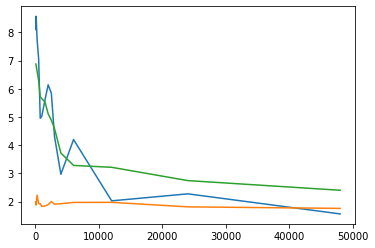

In [334]:
import matplotlib.pyplot as plt
plt.plot(results_df)